## Prepare the workspace

In [2]:
# Update the PATH before proceed,
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [1]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==1.0.0

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0)
ERROR: No matching distribution found for torch==1.0.0


In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available())  

2.0.1
True


In [ ]:
%pip install --ignore-installed torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached torchvision-0.15.2-cp310-cp310-manylinux1_x86_64.whl (6.0 MB)
  Using cached torchaudio-2.0.2-cp310-cp310-manylinux1_x86_64.whl (4.4 MB)
  Using cached nvidia_cusparse_cu11-11.7.4.91-py3-none-manylinux1_x86_64.whl (173.2 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached sympy-1.12.1-py3-none-any.whl (5.7 MB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl (102.6 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl (54.6 MB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinu

In [2]:
%matplotlib inline

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from PIL import Image

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import json

## Load the data


### Data Description
The dataset is split into three parts, training, validation, and testing. For the training, apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet.

The pre-trained networks were trained on the ImageNet dataset where each color channel was normalized separately.Therefore, for all three sets, the means and standard deviations of the images need to be normalized to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(60),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validate_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validate_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validateloader = torch.utils.data.DataLoader(validate_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [5]:
# Map the category label to the actual name
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
device = torch.device("cuda") 
model = models.vgg16(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 262MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Training 

In [7]:
# Freeze the parameters before training
for param in model.parameters():
    param.requires_grad = False

In [8]:
# Build the model
model.classifier = nn.Sequential(
          nn.Linear(25088, 512),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(256, 102),
          nn.LogSoftmax(dim = 1)
        )

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);

In [9]:
# Train the model on the train set
epochs = 5
steps = 0
running_loss = 0
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % 5 == 0:
            validate_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validateloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    validate_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"========= Epoch {epoch+1}/{epochs} ========="
                  f"\nTrain loss:        {running_loss/5:.3f}.. "
                  f"\nValidate loss:     {validate_loss/len(validateloader):.3f}.. "
                  f"\nValidate accuracy: {accuracy/len(validateloader):.3f}")
            running_loss = 0
            model.train()
print("======== FINISH ========")

========= Epoch 1/5 =========
Train loss:        4.631.. 
Validate loss:     4.408.. 
Validate accuracy: 0.090
========= Epoch 1/5 =========
Train loss:        4.416.. 
Validate loss:     4.123.. 
Validate accuracy: 0.112
========= Epoch 1/5 =========
Train loss:        4.166.. 
Validate loss:     3.833.. 
Validate accuracy: 0.185
========= Epoch 1/5 =========
Train loss:        4.034.. 
Validate loss:     3.555.. 
Validate accuracy: 0.227
========= Epoch 1/5 =========
Train loss:        3.749.. 
Validate loss:     3.280.. 
Validate accuracy: 0.308
========= Epoch 1/5 =========
Train loss:        3.476.. 
Validate loss:     2.951.. 
Validate accuracy: 0.351
========= Epoch 1/5 =========
Train loss:        3.376.. 
Validate loss:     2.636.. 
Validate accuracy: 0.409
========= Epoch 1/5 =========
Train loss:        3.035.. 
Validate loss:     2.359.. 
Validate accuracy: 0.455
========= Epoch 1/5 =========
Train loss:        2.939.. 
Validate loss:     2.217.. 
Validate accuracy: 0.460
=

========= Epoch 4/5 =========
Train loss:        1.109.. 
Validate loss:     0.549.. 
Validate accuracy: 0.856
========= Epoch 4/5 =========
Train loss:        0.996.. 
Validate loss:     0.507.. 
Validate accuracy: 0.855
========= Epoch 4/5 =========
Train loss:        1.010.. 
Validate loss:     0.539.. 
Validate accuracy: 0.846
========= Epoch 4/5 =========
Train loss:        1.167.. 
Validate loss:     0.502.. 
Validate accuracy: 0.863
========= Epoch 4/5 =========
Train loss:        1.123.. 
Validate loss:     0.509.. 
Validate accuracy: 0.867
========= Epoch 4/5 =========
Train loss:        0.972.. 
Validate loss:     0.541.. 
Validate accuracy: 0.860
========= Epoch 4/5 =========
Train loss:        0.961.. 
Validate loss:     0.550.. 
Validate accuracy: 0.853
========= Epoch 4/5 =========
Train loss:        1.146.. 
Validate loss:     0.491.. 
Validate accuracy: 0.865
========= Epoch 5/5 =========
Train loss:        1.023.. 
Validate loss:     0.511.. 
Validate accuracy: 0.853
=

## Testing 

In [12]:
# Do validation on the test set
epochs = 5
steps = 0
for epoch in range(epochs):
    if steps % 5 == 0:
        accuracy = 0
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        print(f"========= Epoch {epoch+1}/{epochs} ========="
              f"\nTest loss:     {test_loss/len(testloader):.3f}.. "
              f"\nTest accuracy: {accuracy/len(testloader):.3f}")
print("======== FINISH ========")

========= Epoch 1/5 =========
Test loss:     0.610.. 
Test accuracy: 0.828
========= Epoch 2/5 =========
Test loss:     0.610.. 
Test accuracy: 0.828
========= Epoch 3/5 =========
Test loss:     0.610.. 
Test accuracy: 0.828
========= Epoch 4/5 =========
Test loss:     0.610.. 
Test accuracy: 0.828
========= Epoch 5/5 =========
Test loss:     0.610.. 
Test accuracy: 0.828
======== DONE ========


## Save the checkpoint

In [15]:
checkpoint = {
    'epochs': epochs,
    'learning_rate': 0.001,
    'model_state_dict': model.state_dict(),
    'classifier': model,
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
    'map_class_idx': train_data.class_to_idx
}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint


In [9]:
def load_checkpoint(filepath):
    """Loads a checkpoint and rebuilds the model"""

    checkpoint = torch.load(filepath)
    model = models.vgg16(pretrained = True)
                         
    for param in model.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(
          nn.Linear(25088, 512),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(256, 102),
          nn.LogSoftmax(dim = 1))
    
    model.load_state_dict(checkpoint['model_state_dict'])
    epochs = checkpoint['epochs']
    learning_rate = checkpoint['learning_rate']

    model.class_to_idx = checkpoint['map_class_idx'] 
    
    return model, epochs, learning_rate

In [10]:
model, epochs, learning_rate = load_checkpoint('checkpoint.pth')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Predicting 

In [11]:
# Process a PIL image for use in a model 
# Reuse validate_transforms for simplicity

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a model,
        returns an Numpy array
    '''
    image = Image.open(image)
    
    return validate_transforms(image)
    

In [12]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor"""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [13]:
# Predict the class from an image file

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    model.eval()
    with torch.no_grad():
        logps = model.forward(process_image(image_path).unsqueeze(0)).cpu()
        ps = torch.exp(logps)
        probs, labels = ps.topk(topk, dim=1)
        
        idx_to_class = {model.class_to_idx[i]: i for i in model.class_to_idx}
        classes = list()
        
        idx_to_class = {value : key for key, value in model.class_to_idx.items()} 
        classes = [idx_to_class[i] for i in labels.numpy()[0]]
        
        
        return probs.numpy()[0], classes


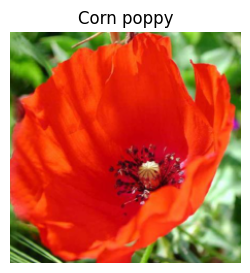

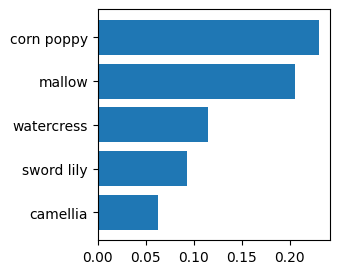

In [20]:
    
img_path = 'flowers/test/26/image_06500.jpg'
img_class = '26'
probs, classes = predict(img_path, model)
image = process_image(img_path)

plt.figure(figsize=(3,3))
axs = imshow(image, ax = plt)
axs.axis('off')
axs.title(cat_to_name[img_class].capitalize())

plt.figure(figsize=(3,3))
labels = [cat_to_name[str(idx)] for idx in classes]
plt.barh(np.arange(len(labels)), np.array(probs), align='center')
plt.yticks(np.arange(len(labels)), labels)
plt.gca().invert_yaxis() 
